# New York City Taxi Trip Duration Estimate 
-  Regression project 

### Kaggle result (RMSE)
- **0.46931 (private)** / 0.47176(public)  - 737 (58%)


### Model

Statsmodels - Regression(OLS)


In [1]:
%matplotlib inline
from taxi_pakage import *
from matplotlib import gridspec
taxi = pd.read_csv("edited_taxi.csv")
taxi['sqrt_log_dist'] = taxi['dist'].apply(lambda x: np.sqrt(np.log1p(x)))
taxi['log_duration'] = taxi['trip_duration'].apply(lambda x: np.log1p(x))
# taxi['velo'] = taxi['dist']/taxi['trip_duration']*3600 # km/h

In [2]:
def hour(x):
    if x < 4  : return 'afternight'
    elif x < 7 : return 'earlymorning'
    elif x > 22 : return 'night'
    else: return x
    
def zone(x):
    if x< 0.1: return 'stopped'
    else: return 'moved'

# taxi['hour'] = taxi['hour'].apply(hour)
taxi['zone'] = taxi['sqrt_log_dist'].apply(zone)
taxi['no_passenger'] = taxi['passenger_count'].apply(lambda x: 1 if x==0 else 0)

In [3]:
test = pd.read_csv("edited_test.csv")
test['sqrt_log_dist'] = test['dist'].apply(lambda x: np.sqrt(np.log1p(x)))
test['zone'] = test['sqrt_log_dist'].apply(zone)
# test['hour'] = test['hour'].apply(hour)
test['no_passenger'] = test['passenger_count'].apply(lambda x: 1 if x==0 else 0)

## Used Features

In [4]:
tx = taxi[['log_duration', 'zone', 'sqrt_log_dist', 'holiday', 'weather_event', 'month', 'hour', 'weekday', 'vendor_id', 'dropoff_latitude', 'dropoff_longitude']]

In [5]:
tx.tail()

,log_duration,zone,sqrt_log_dist,holiday,weather_event,month,hour,weekday,vendor_id,dropoff_latitude,dropoff_longitude
1458639,6.658011,moved,0.894118,0,0,4,13,4,2,40.740170,-73.994911
1458640,6.486161,moved,1.397306,0,1,1,7,6,1,40.796547,-73.970184
1458641,6.639876,moved,1.475462,0,0,4,6,4,2,40.707371,-74.004433
1458642,5.924256,moved,0.859105,0,0,1,15,1,1,40.757107,-73.974632
1458643,5.293305,moved,0.870451,0,0,4,14,1,1,40.790585,-73.972809


### Target: log_duration

### Main feature: sqrt_log_dist

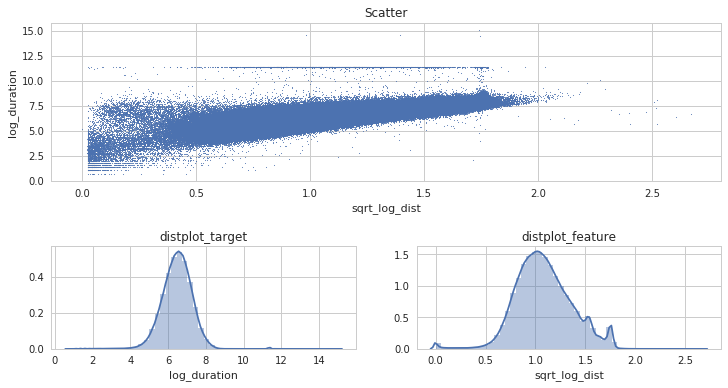

In [6]:
a = tx.pivot_table("log_duration","sqrt_log_dist", aggfunc='mean')[:1000].reset_index()

fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(6,2)

ax1 = fig.add_subplot(gs[0:3,:])
ax1.set_title('Scatter')
ax1.scatter(a['sqrt_log_dist'], a['log_duration'], s=0.5)
ax1.set_ylabel('log_duration')
ax1.set_xlabel('sqrt_log_dist')

ax2 = fig.add_subplot(gs[4:,0])
ax2.set_title('distplot_target')
sns.distplot(tx['log_duration'], ax=ax2)

ax3= fig.add_subplot(gs[4:,1])
ax3.set_title('distplot_feature')
sns.distplot(tx['sqrt_log_dist'], ax=ax3)
plt.show()

### zone - dist, duration 평균

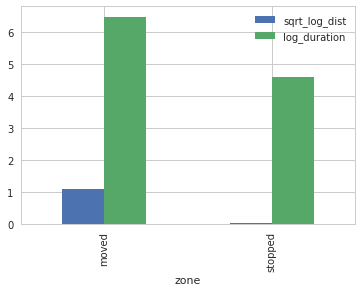

In [7]:
a = tx[['sqrt_log_dist', 'log_duration', 'zone']].groupby('zone').mean()
a.plot(kind='bar')

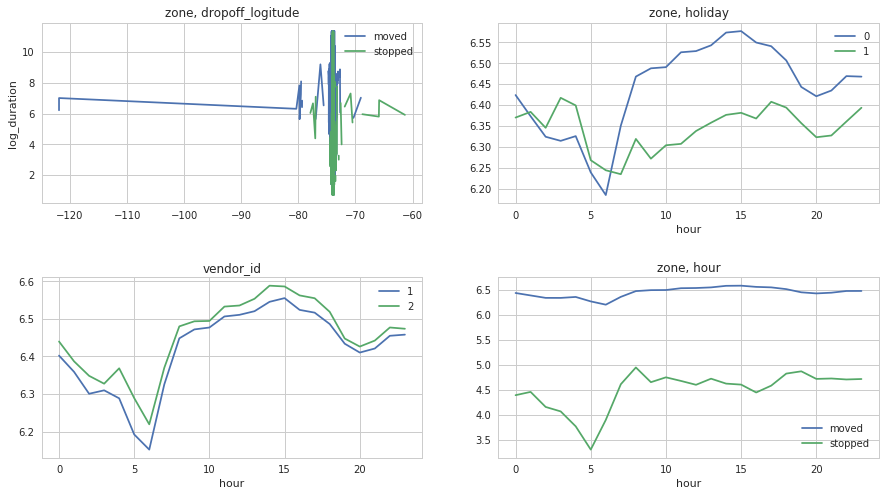

In [8]:
a= tx.pivot_table("log_duration","dropoff_longitude",['zone'], aggfunc='mean')
b= tx.pivot_table("log_duration","hour",["holiday"], aggfunc='mean')
c = tx.pivot_table("log_duration","hour",['vendor_id'], aggfunc='mean')
d = tx.pivot_table("log_duration","hour","zone", aggfunc='mean')

fig = plt.figure(figsize=(15,8))
gs = gridspec.GridSpec(7,2)

ax2 = fig.add_subplot(gs[:3,0])
ax2.set_title('zone, dropoff_logitude')
# ax2.set_xlabel('hour')
ax2.set_ylabel('log_duration')
ax2.plot(a)
ax2.legend(a)

ax3= fig.add_subplot(gs[:3,1])
ax3.set_title('zone, holiday')
ax3.set_xlabel('hour')
ax3.plot(b)
ax3.legend(b)

ax4= fig.add_subplot(gs[4:,0])
ax4.set_title('vendor_id')
ax4.set_xlabel('hour')
ax4.plot(c)
ax4.legend(c)

ax5= fig.add_subplot(gs[4:,1])
ax5.set_title('zone, hour')
ax5.set_xlabel('hour')
ax5.plot(d)
ax5.legend(d)

plt.show()

### weekday, hour, month

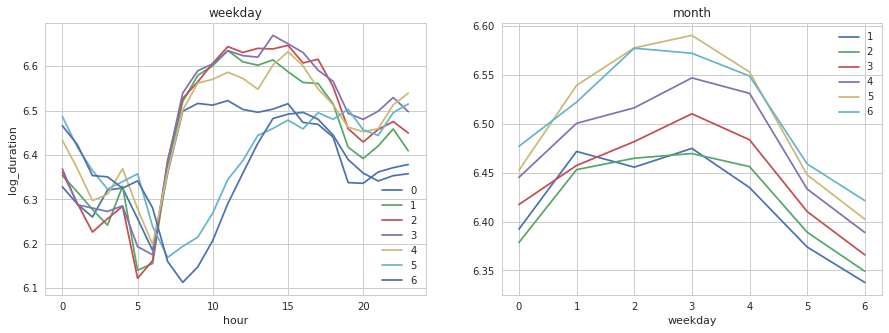

In [9]:
a = tx.pivot_table("log_duration","hour","weekday", aggfunc='mean')
b = tx.pivot_table("log_duration","weekday","month", aggfunc='mean')

fig = plt.figure(figsize=(15,5))
gs = gridspec.GridSpec(1,2)

ax2 = fig.add_subplot(gs[0,0])
ax2.set_title('weekday')
ax2.set_xlabel('hour')
ax2.set_ylabel('log_duration')
ax2.plot(a)
ax2.legend(a)

ax3= fig.add_subplot(gs[0,1])
ax3.set_title('month')
ax3.set_xlabel('weekday')
ax3.plot(b)
ax3.legend(b)
plt.show()

---

## Model


In [10]:
model = sm.OLS.from_formula("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(hour):C(weekday)\
                             + C(no_passenger)\
                             + C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", data = taxi.loc[:100000])
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.658
Method:                 Least Squares   F-statistic:                     1086.
Date:                Tue, 17 Apr 2018   Prob (F-statistic):               0.00
Time:                        18:34:58   Log-Likelihood:                -65113.
No. Observations:              100001   AIC:                         1.306e+05
Df Residuals:                   99823   BIC:                         1.323e+05
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
C(zone)[moved]                            6.1284      0.028    217.179      0.000       6.073       6.184
C(zone)[stopped]                        -22.4771      0.682    -32.969      0.000     -23.813     -21.141
C(holiday)[T.1]                          -0.0949      0.010     -9.518      0.000      -0.114      -0.075
C(weather_event)[T.1]                    -0.0140      0.005     -2.615      0.009      -0.025      -0.004
C(no_passenger)[T.1]                      7.1913      0.465     15.450      0.000       6.279       8.104
C(vendor_id)[T.2]                         0.0179      0.003      6.060      0.000       0.012       0.024
C(weekday)[T.1]                           0.0581      0.039      1.472      0.141      -0.019       0.136
C(weekday)[T.2]                           0.0805      0.037      2.171      0.030       0.008       0.153
C(weekday)[T.3]                           0.0502      0.036      1.405      0.160      -0.020       0.120
C(weekday)[T.4]                           0.1567      0.034      4.638      0.000       0.090       0.223
C(weekday)[T.5]                           0.2716      0.032      8.387      0.000       0.208       0.335
C(weekday)[T.6]                           0.2129      0.033      6.542      0.000       0.149       0.277
C(hour)[T.1]:C(weekday)[0]               -0.0774      0.045     -1.728      0.084      -0.165       0.010
C(hour)[T.2]:C(weekday)[0]               -0.0016      0.050     -0.032      0.975      -0.099       0.096
C(hour)[T.3]:C(weekday)[0]                0.0415      0.060      0.693      0.489      -0.076       0.159
C(hour)[T.4]:C(weekday)[0]               -0.1936      0.054     -3.605      0.000      -0.299      -0.088
C(hour)[T.5]:C(weekday)[0]               -0.1841      0.048     -3.840      0.000      -0.278      -0.090
C(hour)[T.6]:C(weekday)[0]               -0.0434      0.037     -1.175      0.240      -0.116       0.029
C(hour)[T.7]:C(weekday)[0]                0.2258      0.034      6.646      0.000       0.159       0.292
C(hour)[T.8]:C(weekday)[0]                0.4027      0.033     12.076      0.000       0.337       0.468
C(hour)[T.9]:C(weekday)[0]                0.4749      0.033     14.285      0.000       0.410       0.540
C(hour)[T.10]:C(weekday)[0]               0.4519      0.034     13.339      0.000       0.385       0.518
C(hour)[T.11]:C(weekday)[0]               0.4409      0.033     13.168      0.000       0.375       0.507
C(hour)[T.12]:C(weekday)[0]               0.4554      0.033     13.731      0.000       0.390       0.520
C(hour)[T.13]:C(weekday)[0]               0.4405      0.034     13.101      0.000       0.375       0.506
C(hour)[T.14]:C(weekday)[0]               0.4322      0.033     13.053      0.000       0.367       0.497
C(hour)[T

## Check outlier

resid_pearson > 4 기준 아웃라이어 수:  400 /100000
influence >5 기준 아웃라이어 수:  906 /100000
Fox Recommand 기준 아웃라이어 수:  46702 /100000


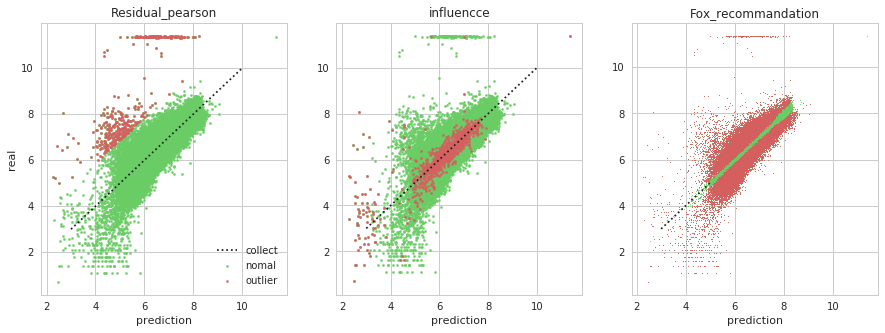

In [11]:
import warnings
warnings.filterwarnings("ignore")

idx= result.resid_pearson > 4
print('resid_pearson > 4 기준 아웃라이어 수: ',len(taxi.loc[:100000][idx]), '/100000')

plt.figure(figsize=(15,5))
plt.subplot(131)
Price_predicted = result.predict(taxi.loc[:100000])
plt.scatter(Price_predicted, taxi.loc[:100000].log_duration,c='g', s=5, label='nomal')
plt.scatter(Price_predicted[idx], taxi.loc[:100000][idx].log_duration, c='r', s=5, label='outlier')
plt.plot([3, 10], [3, 10], 'k:', label="collect", alpha=0.99)
plt.legend()
plt.title('Residual_pearson')
plt.xlabel('prediction')
plt.ylabel('real')

plt.subplot(132)

influence = result.get_influence()
h = influence.hat_matrix_diag
idx = h > 5 * h.mean()
print('influence >5 기준 아웃라이어 수: ',len(taxi.loc[:100000][idx]), '/100000')
Price_predicted = result.predict(taxi.loc[:100000])
plt.scatter(Price_predicted, taxi.loc[:100000].log_duration, c='g', s=5)
plt.scatter(Price_predicted[idx], taxi.loc[:100000][idx].log_duration, c='r', s=5)
plt.plot([3, 10], [3, 10], 'k:', label="collect", alpha=0.99)
plt.title('influencce')
plt.xlabel('prediction')

plt.subplot(133)

influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4/(len(taxi) - 142 -1)
idx = np.where(cooks_d2 > fox_cr)[0]
print('Fox Recommand 기준 아웃라이어 수: ',len(taxi.loc[:100000].loc[idx]), '/100000')

Price_predicted = result.predict(taxi.loc[:100000])
plt.plot([3, 5], [3, 5], 'k:', label="collect", alpha=0.99)
plt.scatter(Price_predicted, taxi.loc[:100000].log_duration, c='g', s=0.5)
plt.scatter(Price_predicted[idx], taxi.loc[:100000].loc[idx].log_duration, c='r', s=0.5)
plt.title('Fox_recommandation')
plt.xlabel('prediction')

plt.show()

그러나 아웃라이어를 제거하지 않는 것이 kaggle 결과가 높았다.
- 테스트 데이터에도 아웃라이어가 있기 때문에 이에 대한 대비가 필요

In [12]:
idx= result.resid_pearson > 2

t1 = taxi.loc[:100000]

len(t1[~idx]), len(t1[idx])

(98288, 1713)

In [13]:
model1 = sm.OLS.from_formula("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(hour):C(weekday)\
                             + C(no_passenger)\
                             + C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", data =t1[~idx])
result1 = model1.fit()

result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           log_duration   R-squared:                       0.757
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     1725.
Date:                Tue, 17 Apr 2018   Prob (F-statistic):               0.00
Time:                        18:35:35   Log-Likelihood:                -44634.
No. Observations:               98288   AIC:                         8.962e+04
Df Residuals:                   98110   BIC:                         9.131e+04
Df Model:                         177                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
C(zone)[moved]                            6.1205      0.023    262.196      0.000       6.075       6.166
C(zone)[stopped]                        -17.2875      0.713    -24.250      0.000     -18.685     -15.890
C(holiday)[T.1]                          -0.0977      0.008    -11.828      0.000      -0.114      -0.082
C(weather_event)[T.1]                    -0.0107      0.004     -2.418      0.016      -0.019      -0.002
C(no_passenger)[T.1]                      8.1026      0.382     21.188      0.000       7.353       8.852
C(vendor_id)[T.2]                         0.0003      0.002      0.112      0.911      -0.005       0.005
C(weekday)[T.1]                           0.0446      0.033      1.363      0.173      -0.020       0.109
C(weekday)[T.2]                           0.0869      0.031      2.834      0.005       0.027       0.147
C(weekday)[T.3]                           0.0477      0.030      1.611      0.107      -0.010       0.106
C(weekday)[T.4]                           0.1676      0.028      6.003      0.000       0.113       0.222
C(weekday)[T.5]                           0.2479      0.027      9.244      0.000       0.195       0.300
C(weekday)[T.6]                           0.2293      0.027      8.524      0.000       0.177       0.282
C(hour)[T.1]:C(weekday)[0]               -0.0628      0.037     -1.695      0.090      -0.135       0.010
C(hour)[T.2]:C(weekday)[0]               -0.0021      0.041     -0.052      0.958      -0.083       0.078
C(hour)[T.3]:C(weekday)[0]                0.0272      0.050      0.546      0.585      -0.070       0.125
C(hour)[T.4]:C(weekday)[0]               -0.1718      0.044     -3.887      0.000      -0.258      -0.085
C(hour)[T.5]:C(weekday)[0]               -0.1676      0.040     -4.236      0.000      -0.245      -0.090
C(hour)[T.6]:C(weekday)[0]               -0.0236      0.031     -0.773      0.439      -0.083       0.036
C(hour)[T.7]:C(weekday)[0]                0.2186      0.028      7.763      0.000       0.163       0.274
C(hour)[T.8]:C(weekday)[0]                0.4158      0.028     15.078      0.000       0.362       0.470
C(hour)[T.9]:C(weekday)[0]                0.4792      0.028     17.409      0.000       0.425       0.533
C(hour)[T.10]:C(weekday)[0]               0.4567      0.028     16.274      0.000       0.402       0.512
C(hour)[T.11]:C(weekday)[0]               0.4605      0.028     16.618      0.000       0.406       0.515
C(hour)[T.12]:C(weekday)[0]               0.4572      0.027     16.637      0.000       0.403       0.511
C(hour)[T.13]:C(weekday)[0]               0.4446      0.028     15.978      0.000       0.390       0.499
C(hour)[T.14]:C(weekday)[0]               0.4423      0.027     16.143      0.000       0.389       0.496
C(hour)[T

### Cross Validation

In [14]:
score, result_set = cross_validater("log_duration ~ \
                             + C(zone)/scale(sqrt_log_dist)\
                             + C(holiday)\
                             + C(weather_event)\
                             + C(hour):C(weekday)\
                             + C(no_passenger)\
                             + C(vendor_id)\
                             + scale(month) \
                             + scale(dropoff_latitude)+ scale(dropoff_longitude) \
                             + 0", taxi.loc[:300000], 3, r_seed=0, target_log=True)

In [15]:
score

[0.47029615540578135, 0.46986433427353597, 0.46858936118851113]

In [16]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.653,264737.373,266554.054,618.611,0.0,0.0,0.0,2.004,log_duration ~ + ...
1,0.652,264860.031,266676.712,627.213,0.0,0.0,0.0,2.002,log_duration ~ + ...
2,0.653,265337.976,267154.658,623.583,0.0,0.0,0.0,2.002,log_duration ~ + ...


---

## 검정

이 모델의 잔차는 정규성을 띄지 않는다.

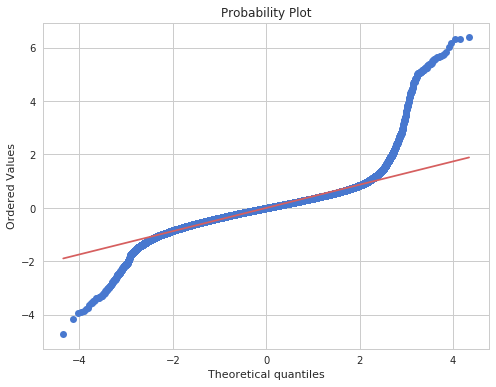

In [17]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)
plt.show()

## zone:dist
당연하게도, zone에 따라 거리 비례 이동시간이 달라진다. (기울기 변화)

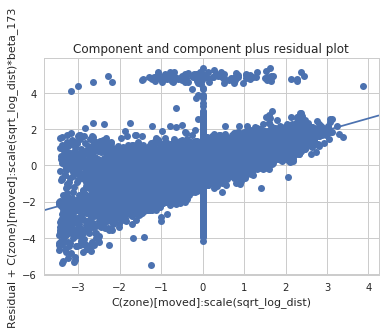

In [18]:
sm.graphics.plot_ccpr(result, "C(zone)[moved]:scale(sqrt_log_dist)")
plt.show()

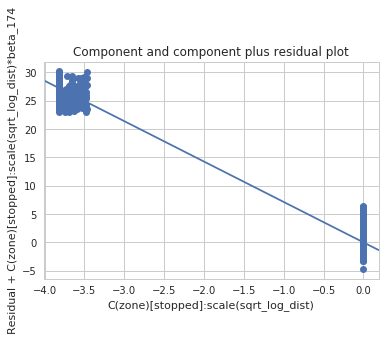

In [19]:
sm.graphics.plot_ccpr(result, "C(zone)[stopped]:scale(sqrt_log_dist)")
plt.show()

## zone

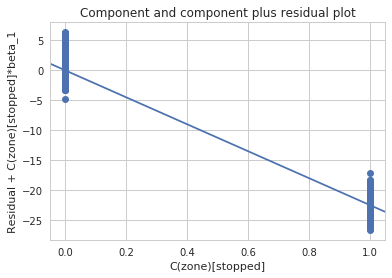

In [20]:
sm.graphics.plot_ccpr(result, "C(zone)[stopped]") 
plt.show()

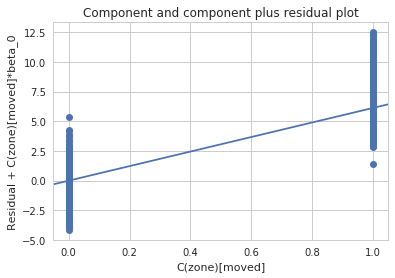

In [21]:
sm.graphics.plot_ccpr(result, "C(zone)[moved]") 
plt.show()

## weekday:hour
- 날짜와 시간 조합에 따라 duration이 달라진다.

#### 월요일 오전 7시
- duration이 길어진다 - 출근길이라 속도가 안나옴
- coef : 0.2233

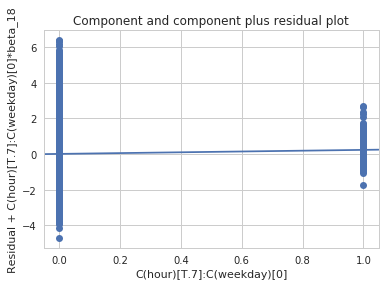

In [22]:
sm.graphics.plot_ccpr(result, "C(hour)[T.7]:C(weekday)[0]")
plt.show()

#### 토요일 오전 6시
- duration이 짧다 - 휴일 아침이라 빠르게 도착
- coef : -0.3800

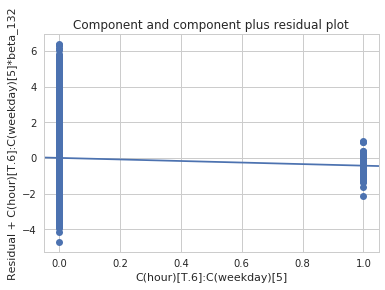

In [23]:
sm.graphics.plot_ccpr(result, "C(hour)[T.6]:C(weekday)[5]")
plt.show()

### C(weather_event)[T.1]	

- 날씨가 매우 좋지 않았던 날의 경우, duration이 짧아진다 - 장거리 외출 자제
- coef : -0.0140 / 하지만 미미한 정도

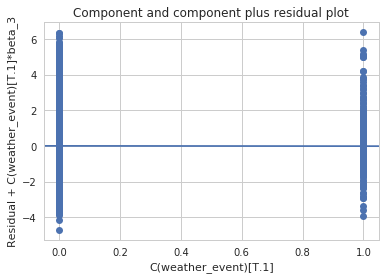

In [24]:
sm.graphics.plot_ccpr(result, "C(weather_event)[T.1]") 
plt.show()

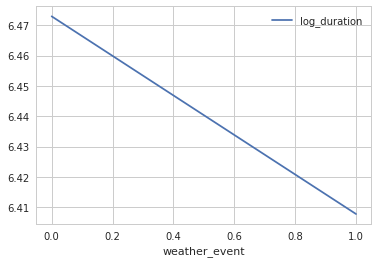

In [25]:
taxi.pivot_table("log_duration", "weather_event", aggfunc='mean').plot()
plt.show()

## holiday 

휴일의 평균 duration이 짧다
- coef : -0.0969

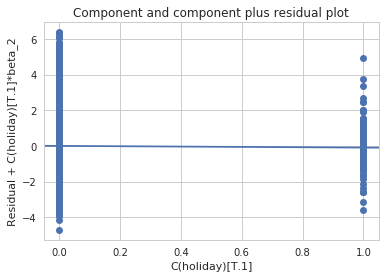

In [26]:
sm.graphics.plot_ccpr(result, "C(holiday)[T.1]")
plt.show()

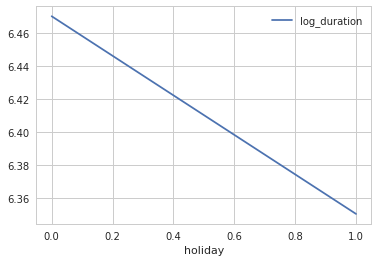

In [27]:
taxi.pivot_table("log_duration", "holiday", aggfunc='mean').plot()
plt.show()

## month 

날이 풀릴 수록 이동 시간이 증가한다 
- 외출 증가
- coef : 0.0251

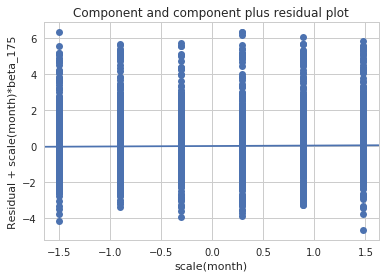

In [28]:
sm.graphics.plot_ccpr(result, "scale(month)")
plt.show()

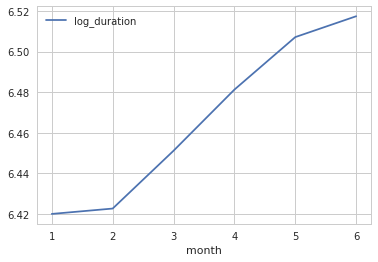

In [29]:
taxi.pivot_table("log_duration", "month", aggfunc='mean').plot()
plt.show()

## vendor_id

2번 밴더를 이용하는 택시의 평균 이동시간이 길다
- coef 0.0226

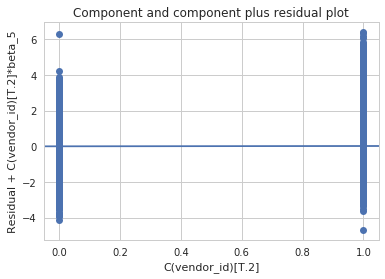

In [30]:
sm.graphics.plot_ccpr(result, "C(vendor_id)[T.2]")
plt.show()

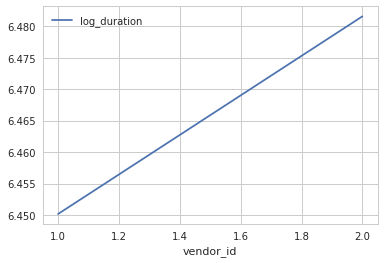

In [31]:
taxi.pivot_table("log_duration","vendor_id", aggfunc='mean').plot()

###  scale(sqrt_log_dist) : vendor_id

vendor 2 경우에도 거리가 길어지면 이동 시간이 줄어들지만 기울기가 많이 작아진다.
- coef : -0.0356 
- coef of scale(sqrt_log_dist)  : -6.7921

In [33]:
# sm.graphics.plot_ccpr(result, "scale(sqrt_log_dist):C(vendor_id)[T.2]") 
# plt.show()

## no_passenger

승객이 없는 경우 duration이 짧아진다.
- coef : -1.5421

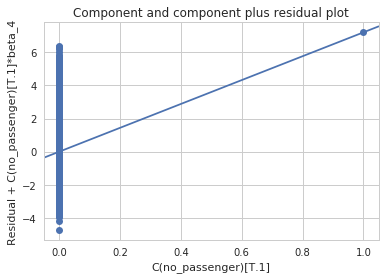

In [34]:
sm.graphics.plot_ccpr(result, "C(no_passenger)[T.1]")
plt.show()

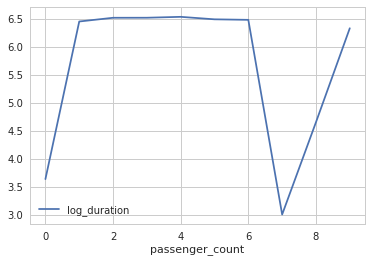

In [35]:
taxi.pivot_table("log_duration","passenger_count", aggfunc='mean').plot()

## dropoff_latitude

내린 장소의 latitude가 증가할수록 duration이 짧아진다.
- coef : -0.0439

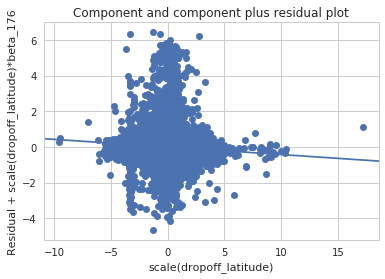

In [36]:
sm.graphics.plot_ccpr(result, "scale(dropoff_latitude)")
plt.show()

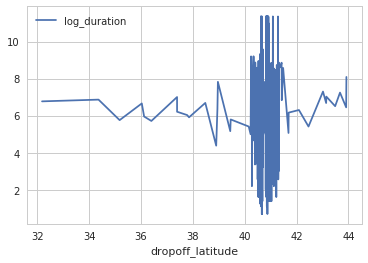

In [37]:
taxi.pivot_table("log_duration","dropoff_latitude", aggfunc='mean').plot()
plt.show()

## dropoff_longitude

내린 장소의 longitude가 증가할수록 duration이 짧아진다.
- coef : -0.0231

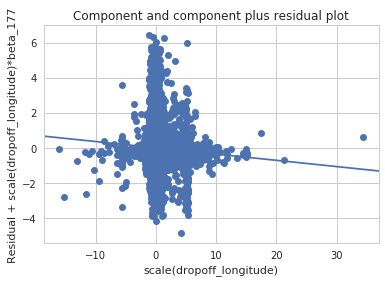

In [38]:
sm.graphics.plot_ccpr(result, "scale(dropoff_longitude)")
plt.show()

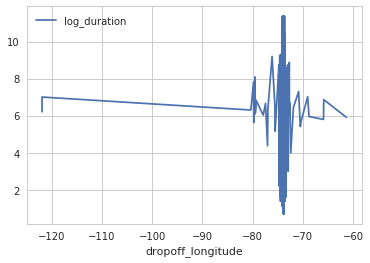

In [39]:
taxi.pivot_table("log_duration","dropoff_longitude", aggfunc='mean').plot()
plt.show()

---

In [40]:
# 테스트 데이터를 통해 y값 예측
y_hat = result.predict(test)

In [41]:
y_hat = y_hat.apply(lambda x: (round(np.exp(x))))
ans = pd.concat([test['id'], y_hat], axis=1)
ans.rename(columns={'id':'id' , 0:'trip_duration'}, inplace=True)

In [42]:
len(ans[pd.isna(ans['trip_duration'])])

0

In [43]:
ans[ans.iloc[:,1]>10000000]

,id,trip_duration
324125,id0505885,1.662237e+24


In [44]:
test.loc[324125] 

id                              id0505885
vendor_id                               2
pickup_datetime       2016-03-29 14:28:46
passenger_count                         2
pickup_longitude                 -121.933
pickup_latitude                   37.3896
dropoff_longitude                -121.933
dropoff_latitude                  37.3894
store_and_fwd_flag                      0
dist                            0.0295004
month                                   3
day                                    29
hour                                   14
weekday                                 1
holiday                                 0
work                                    1
dhour                                   3
weather_event                           1
sqrt_log_dist                     0.17051
zone                                moved
no_passenger                            0
Name: 324125, dtype: object

In [45]:
ans['trip_duration'].loc[324125] =950 # 너무 큰 숫자는 int변환이 불가능
ans['trip_duration'] = ans['trip_duration'].apply(lambda x: int(x))
# Kaggle 제출파일
ans.to_csv('basic_model.csv', index=False)